# Introduction
In this short blog post, I want to show you an idea where you take some very detailed datasets from a software project and transform it into a representation where management can reason about. For this,

* we take the utilization of a web application measured by the code coverage during user interactions
* we estimate the investments in the software by the number of changes. 
* we aggregate the data to something management can understand
* we visualize the results in a SWOT (Strengths, Weaknesses, Opportunities, Threats) matrix.

Let's do this!

## Utilization of a production system
A proxy for utilization, we've take the code coverage of a web application during the live operation with the user. We've collected that data by attaching the JaCoCo agent to the Java process (for details on how to do that see my blog post ["Visualizing Production Coverage with JaCoCo, Pandas and D3"](https://www.feststelltaste.de/visualizing-production-coverage-with-jacoco-pandas-and-d3/)).

The results is a dataset with covered lines per class. We read that into a Pandas DataFrame.

In [14]:
import pandas as pd

coverage = pd.read_csv("datasets/jacoco_production_coverage_spring_petclinic.csv")
coverage.head()

,PACKAGE,CLASS,LINE_MISSED,LINE_COVERED
0,org.springframework.samples.petclinic,PetclinicInitializer,0,24
1,org.springframework.samples.petclinic.model,NamedEntity,1,4
2,org.springframework.samples.petclinic.model,Specialty,0,1
3,org.springframework.samples.petclinic.model,PetType,0,1
4,org.springframework.samples.petclinic.model,Vets,4,0


We need to calculate some additional variables for our analysis later on: The lines of code per class and the ratio of the covered lines of code to all lines of code per class.

In [2]:
coverage['lines'] = coverage.LINE_MISSED + coverage.LINE_COVERED
coverage['covered'] = coverage.LINE_COVERED / coverage.lines
coverage.head()

,PACKAGE,CLASS,LINE_MISSED,LINE_COVERED,lines,covered
0,org.springframework.samples.petclinic,PetclinicInitializer,0,24,24,1.0
1,org.springframework.samples.petclinic.model,NamedEntity,1,4,5,0.8
2,org.springframework.samples.petclinic.model,Specialty,0,1,1,1.0
3,org.springframework.samples.petclinic.model,PetType,0,1,1,1.0
4,org.springframework.samples.petclinic.model,Vets,4,0,4,0.0


Next, we create an unique identifier for connecting the coverage data to the number of changes per class. We choose the full qualified name ("fqn") of a class as key for this, set this variable as index and only take the columns that we need later.

In [3]:
coverage['fqn'] = coverage.PACKAGE + "." + coverage.CLASS
coverage_per_class = coverage.set_index('fqn')[['lines', 'covered']]
coverage_per_class.head()

,lines,covered
fqn,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0
org.springframework.samples.petclinic.model.NamedEntity,5,0.8
org.springframework.samples.petclinic.model.Specialty,1,1.0
org.springframework.samples.petclinic.model.PetType,1,1.0
org.springframework.samples.petclinic.model.Vets,4,0.0


# Investments in code
As proxy for the investments we took into our software, we choose the number of changes per file. For this, we need a log of our version control system. With Git, a simple numstat log does the job. We can get a list for each change of a file including the added and deleted lines with the command
```
git log --no-merges --no-renames --numstat --pretty=format:""
```
We kind of hacked the git log pretty format option, but it does the job. We read that dataset into a DataFrame as well, using the tabular as separator and specifying some column names manually.

In [4]:
changes = pd.read_csv(
    "datasets/git_log_numstat_spring_petclinic.log",
    sep="\t",
    names=['additions', 'deletions', 'path'])
changes.head()

,additions,deletions,path
0,4,5,src/test/java/org/springframework/samples/petc...
1,25,7,src/test/java/org/springframework/samples/petc...
2,21,9,src/test/java/org/springframework/samples/petc...
3,23,3,src/test/java/org/springframework/samples/petc...
4,10,6,src/test/java/org/springframework/samples/petc...


As with the coverage data, we need an unique identifier per class. We can create that based on the path of each file.

In [5]:
changes['fqn'] = changes.path.str.extract(
    "/java/(.*)\.java",
    expand=True)[0]
changes['fqn'] = changes.fqn.str.replace("/", ".")
changes['fqn'][0]

'org.springframework.samples.petclinic.web.CrashControllerTests'

Different to the coverage dataset, we have multiple entries per file (for each change of that file). We need to group the changes by the `fqn` of each file or class respectively. We just take the path column that holds the number of changes for each class and rename that column to `changes`. The result is a Series with the number of changes per file.

In [6]:
changes_per_file = changes.groupby('fqn').path.count()
changes_per_file.name = "changes"
changes_per_file.head()

fqn
org.springframework.samples.petclinic.AbstractClinicTests             5
org.springframework.samples.petclinic.AbstractOwnerRepositoryTests    6
org.springframework.samples.petclinic.AbstractPetRepositoryTests      6
org.springframework.samples.petclinic.AbstractVetRepositoryTests      4
org.springframework.samples.petclinic.AbstractVisitRepositoryTests    5
Name: changes, dtype: int64

# Joining of the datasets
Next, we can join the two different datasets with the DataFrames' `join` method.

In [7]:
analysis = coverage_per_class.join(changes_per_file)
analysis.head()

,lines,covered,changes
fqn,,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0,1.0
org.springframework.samples.petclinic.model.NamedEntity,5,0.8,3.0
org.springframework.samples.petclinic.model.Specialty,1,1.0,2.0
org.springframework.samples.petclinic.model.PetType,1,1.0,4.0
org.springframework.samples.petclinic.model.Vets,4,0.0,5.0


# Creating a higher technical view
OK, now to the key idea of this analysis. We need to raise the very fine-granular data on class level to a more higher-level where we can reason about in a better way. For this, we derive higher-level perspectives based on the `fqn` of the classes. For technical components, we can do this in our case based on the package name  because the last part of the package name contains the name of the technical component. 

In [8]:
analysis['tech'] = analysis.index.str.split(".").str[-2]
analysis.head()

,lines,covered,changes,tech
fqn,,,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0,1.0,petclinic
org.springframework.samples.petclinic.model.NamedEntity,5,0.8,3.0,model
org.springframework.samples.petclinic.model.Specialty,1,1.0,2.0,model
org.springframework.samples.petclinic.model.PetType,1,1.0,4.0,model
org.springframework.samples.petclinic.model.Vets,4,0.0,5.0,model


We can now aggregate our fine-granular data to a higher-level representation by grouping the data accordingly to the technical components. For the `agg` function, we provide a dictionary with the aggregation methods for each column.

In [9]:
tech_insights = analysis.groupby('tech').agg({
    "lines" : "sum",
    "covered": "mean",
    "changes" : "sum"
    })
tech_insights.head()

,lines,covered,changes
tech,,,
jdbc,150,0.000000,93.0
jpa,28,0.691558,39.0
model,108,0.739048,44.0
petclinic,24,1.000000,1.0
service,18,0.888889,12.0


With the help of a (self-written) little visualzation, we can now create a SWOT matrix from our data.

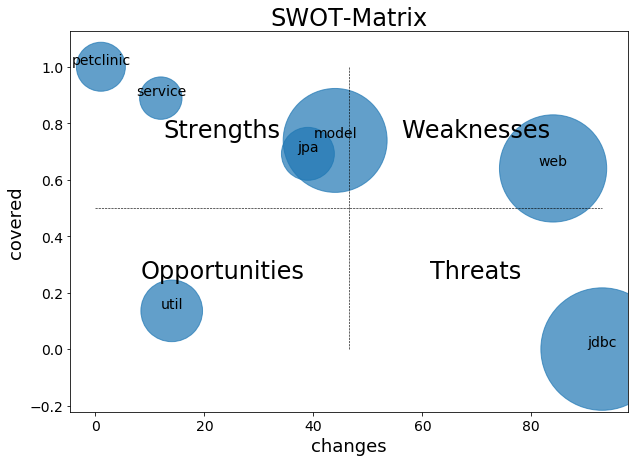

In [15]:
%matplotlib inline
from lib.ausi import portfolio
portfolio.plot_diagram(tech_insights, "changes", "covered", "lines");

**Discussion**  
* In the lower right, we can see that we changed the `jdbc` component very often (aka invested much money) but the component isn't used at all. A clear failure of investments (OK, in this case, it's an alternative implementation of the database access, but we could also delete this code completely without any side effects).
* Above, we see that we also invested heavily in the `web` component, but this isn't used as much as it should be (in relation to the changes). Maybe we can find code in this component that isn't needed anymore.
* The `petclinic` (a base component), `service`, `jpa` and `model` components in the upper left are used very often with low changes (aka investments). This is good!

# Creating a domain  view
Next, we want to create a view that non-technical people can understand. For this, we use the naming schema of the classes to identify which business domain each class belongs to.

In [11]:
analysis['domain'] = "Other"

domains = ["Owner", "Pet", "Visit", "Vet", "Specialty", "Clinic"]
for domain in domains:
    analysis.loc[analysis.index.str.contains(domain), 'domain'] = domain

analysis.head()

,lines,covered,changes,tech,domain
fqn,,,,,
org.springframework.samples.petclinic.PetclinicInitializer,24,1.0,1.0,petclinic,Pet
org.springframework.samples.petclinic.model.NamedEntity,5,0.8,3.0,model,Other
org.springframework.samples.petclinic.model.Specialty,1,1.0,2.0,model,Specialty
org.springframework.samples.petclinic.model.PetType,1,1.0,4.0,model,Pet
org.springframework.samples.petclinic.model.Vets,4,0.0,5.0,model,Vet


Like with the technical components, we group the business aspects accordingly but also translate the technical terms into non-technical ones.

In [12]:
insights = analysis.groupby('domain').agg({
    "covered": "mean",
    "lines" : "sum",
    "changes" : "sum"
    })
insights.columns = \
    ['Utilization', 'Investment', 'Size']
insights.head()

,Utilization,Investment,Size
domain,,,
Clinic,0.888889,18,12.0
Other,0.480208,57,32.0
Owner,0.549495,130,59.0
Pet,0.594156,153,81.0
Specialty,1.000000,1,2.0


Again, we plot a SWOT matrix with the data in the DataFrame.

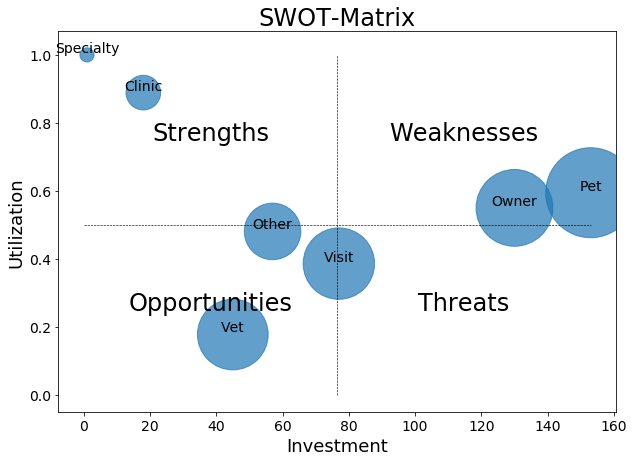

In [13]:
portfolio.plot_diagram(insights, "Investment", "Utilization", "Size");

**Discussion**
* The investments into the classes around `Clinic` in the upper left of the matrix were worthwhile.
* We have to have a look at the trend of `Pet` and `Owner` related classes because albeit we've invested heavily in this parts, they aren't used so much.
* For the `Other`, `Visit` and `Vet` components in the middle and lower left, there is a good chance to get these right in the near future by only developing the parts further that are really needed.

# Conclusion
OK, we've seen how we can take some very fine-granular dataset, combine them and bring them to a higher-level perspective. We've also visualized the results of our analysis with a SWOT matrix to quickly spot parts of our software system that are good or bad investments.


What do you think about this approach? Do you like the idea? Or is this completely nonsense? Please leave me a comment!